# Perkenalan

**Nama**    : Ahmad Qais Alfiansyah  
**Batch**   : RMT-027  
**Project** : Live Code 7  

## Latar Belakang Masalah
Saya mendapatkan sebuah project dari salah satu hotel untuk memprediksi apakah tamu mereka akan melakukan pembatalan pemesanan atau tidak berdasarkan data history sebelumnya.  

Data history yang dimaksud adalah data pemesanan kamar dimana setiap baris itu adalah riwayat pemesanan (Berdasarkan Booking ID). Dataset ini lengkap dengan tipe kamar apa yang dipesan, jenis meals apa yang dipesan hingga pada akhirnya statusnya cancel atau tidak.  

Adapun saya menggunakan model ANN khususnya Sequential dan Functional API dengan metode evaluasi yang saya gunakan:  
**Recall**  
Hal ini karena pihak hotel harus meminimalisir False Negative. Jika dibayangkan, pihak hotel memprediksi cancel tetapi ternyata tamu tersebut tidak cancel. Saya akan menggunakan classification report untuk menganlisa hasil ini.
  

# Import Libraries

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, concatenate
from tensorflow.keras import Model

import pickle

color_codes = [
    '#1d3d71',
    '#f26634',
    '#3993dd',
    '#8ea604',
    '#f5bb00',
    '#468c98',
    '#2ec4b6',
    '#629460',
    '#a4243b',
    '#dc0073'
]


# Data Loading

In [61]:
pd.set_option('display.max_columns', 70)
df= pd.read_csv('/content/hotel.csv')
df.head(3)

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,ID00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,ID00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,ID00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled


## Informasi Dataset

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

Berdasarkan informasi data di atas, terlihat bahwa dataset terdiri dari lebih dari 36 ribu Booking dan terdapat 19 kolom termasuk kolom Booking Status nya.  

Datatype terdiri dari Object, Interger dan Float. Selanjutnya saya akan cek apakah terdapat Missing Value dan Duplicate value atau tidak.  

## Missing Value

In [63]:
df.duplicated().sum()

0

Tidak ada missin Value pada dataset

## Duplicate Value

In [64]:
df.duplicated().sum()

0

Duplicate Value juga tidak ada dalam dataset ini.

## Kardinalitas

Pada tahapan ini saya akan mencoba membagi data berdasarkan kardinalitasnya.  

In [65]:
df.nunique()

Booking_ID                              36275
no_of_adults                                5
no_of_children                              6
no_of_weekend_nights                        8
no_of_week_nights                          18
type_of_meal_plan                           4
required_car_parking_space                  2
room_type_reserved                          7
lead_time                                 352
arrival_year                                2
arrival_month                              12
arrival_date                               31
market_segment_type                         5
repeated_guest                              2
no_of_previous_cancellations                9
no_of_previous_bookings_not_canceled       59
avg_price_per_room                       3930
no_of_special_requests                      6
booking_status                              2
dtype: int64

Terlihat dengan jelas, Booking ID jumlahnya nilai uniknya sama dengan Jumlah baris data. Dan terdapat beberapa kategori serta numerical columns

In [66]:
df.dtypes

Booking_ID                               object
no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                        object
required_car_parking_space                int64
room_type_reserved                       object
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                      object
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                           object
dtype: object

Saya buatkan variabel2 baru berdasarkan tipe data dan tipe kardinalitasnya

In [67]:
threshold = 10
obj_hi_card = []
obj_lo_card = []
num_lo_card = []
num_hi_card = []

for col in df.columns:
    if df[col].dtype == 'object':
        if df[col].nunique() >= threshold:
            obj_hi_card.append(col)
        else:
            obj_lo_card.append(col)
    elif df[col].dtype in ['int', 'float']:
        if df[col].nunique() <= threshold:
            num_lo_card.append(col)
        else:
            num_hi_card.append(col)
print(f"Kategori object dengan kardinalitas tinggi, nilai unik di atas {threshold} adalah:\n{obj_hi_card}")
print(f"Kategori object dengan kardinalitas rendah, nilai unik di bawah {threshold} adalah:\n{obj_lo_card}")
print(f"Kategori numeric dengan kardinalitas rendah, nilai unik di bawah {threshold} adalah:\n{num_lo_card}")
print(f"Kategori numeric dengan kardinalitas tinggi, nilai unik di atas {threshold} adalah:\n{num_hi_card}")


Kategori object dengan kardinalitas tinggi, nilai unik di atas 10 adalah:
['Booking_ID']
Kategori object dengan kardinalitas rendah, nilai unik di bawah 10 adalah:
['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'booking_status']
Kategori numeric dengan kardinalitas rendah, nilai unik di bawah 10 adalah:
['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'required_car_parking_space', 'arrival_year', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_special_requests']
Kategori numeric dengan kardinalitas tinggi, nilai unik di atas 10 adalah:
['no_of_week_nights', 'lead_time', 'arrival_month', 'arrival_date', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room']


Kenapa saya melakukan ini? Ini saya lakukan guna memudahkan saya untuk melakukan EDA. Tepatnya untuk cek distribusi data dan melakukan visualisasi data. Kolom yang memiliki kardinalitas rendah, jumlah classnya sedikit akan saya visualisasikan menggunakan Countplot. Untuk yang kardinalitas tinggi akan saya gunakan histplot.  

# Exploratory Data Analysis (EDA)

## Distribusi Data

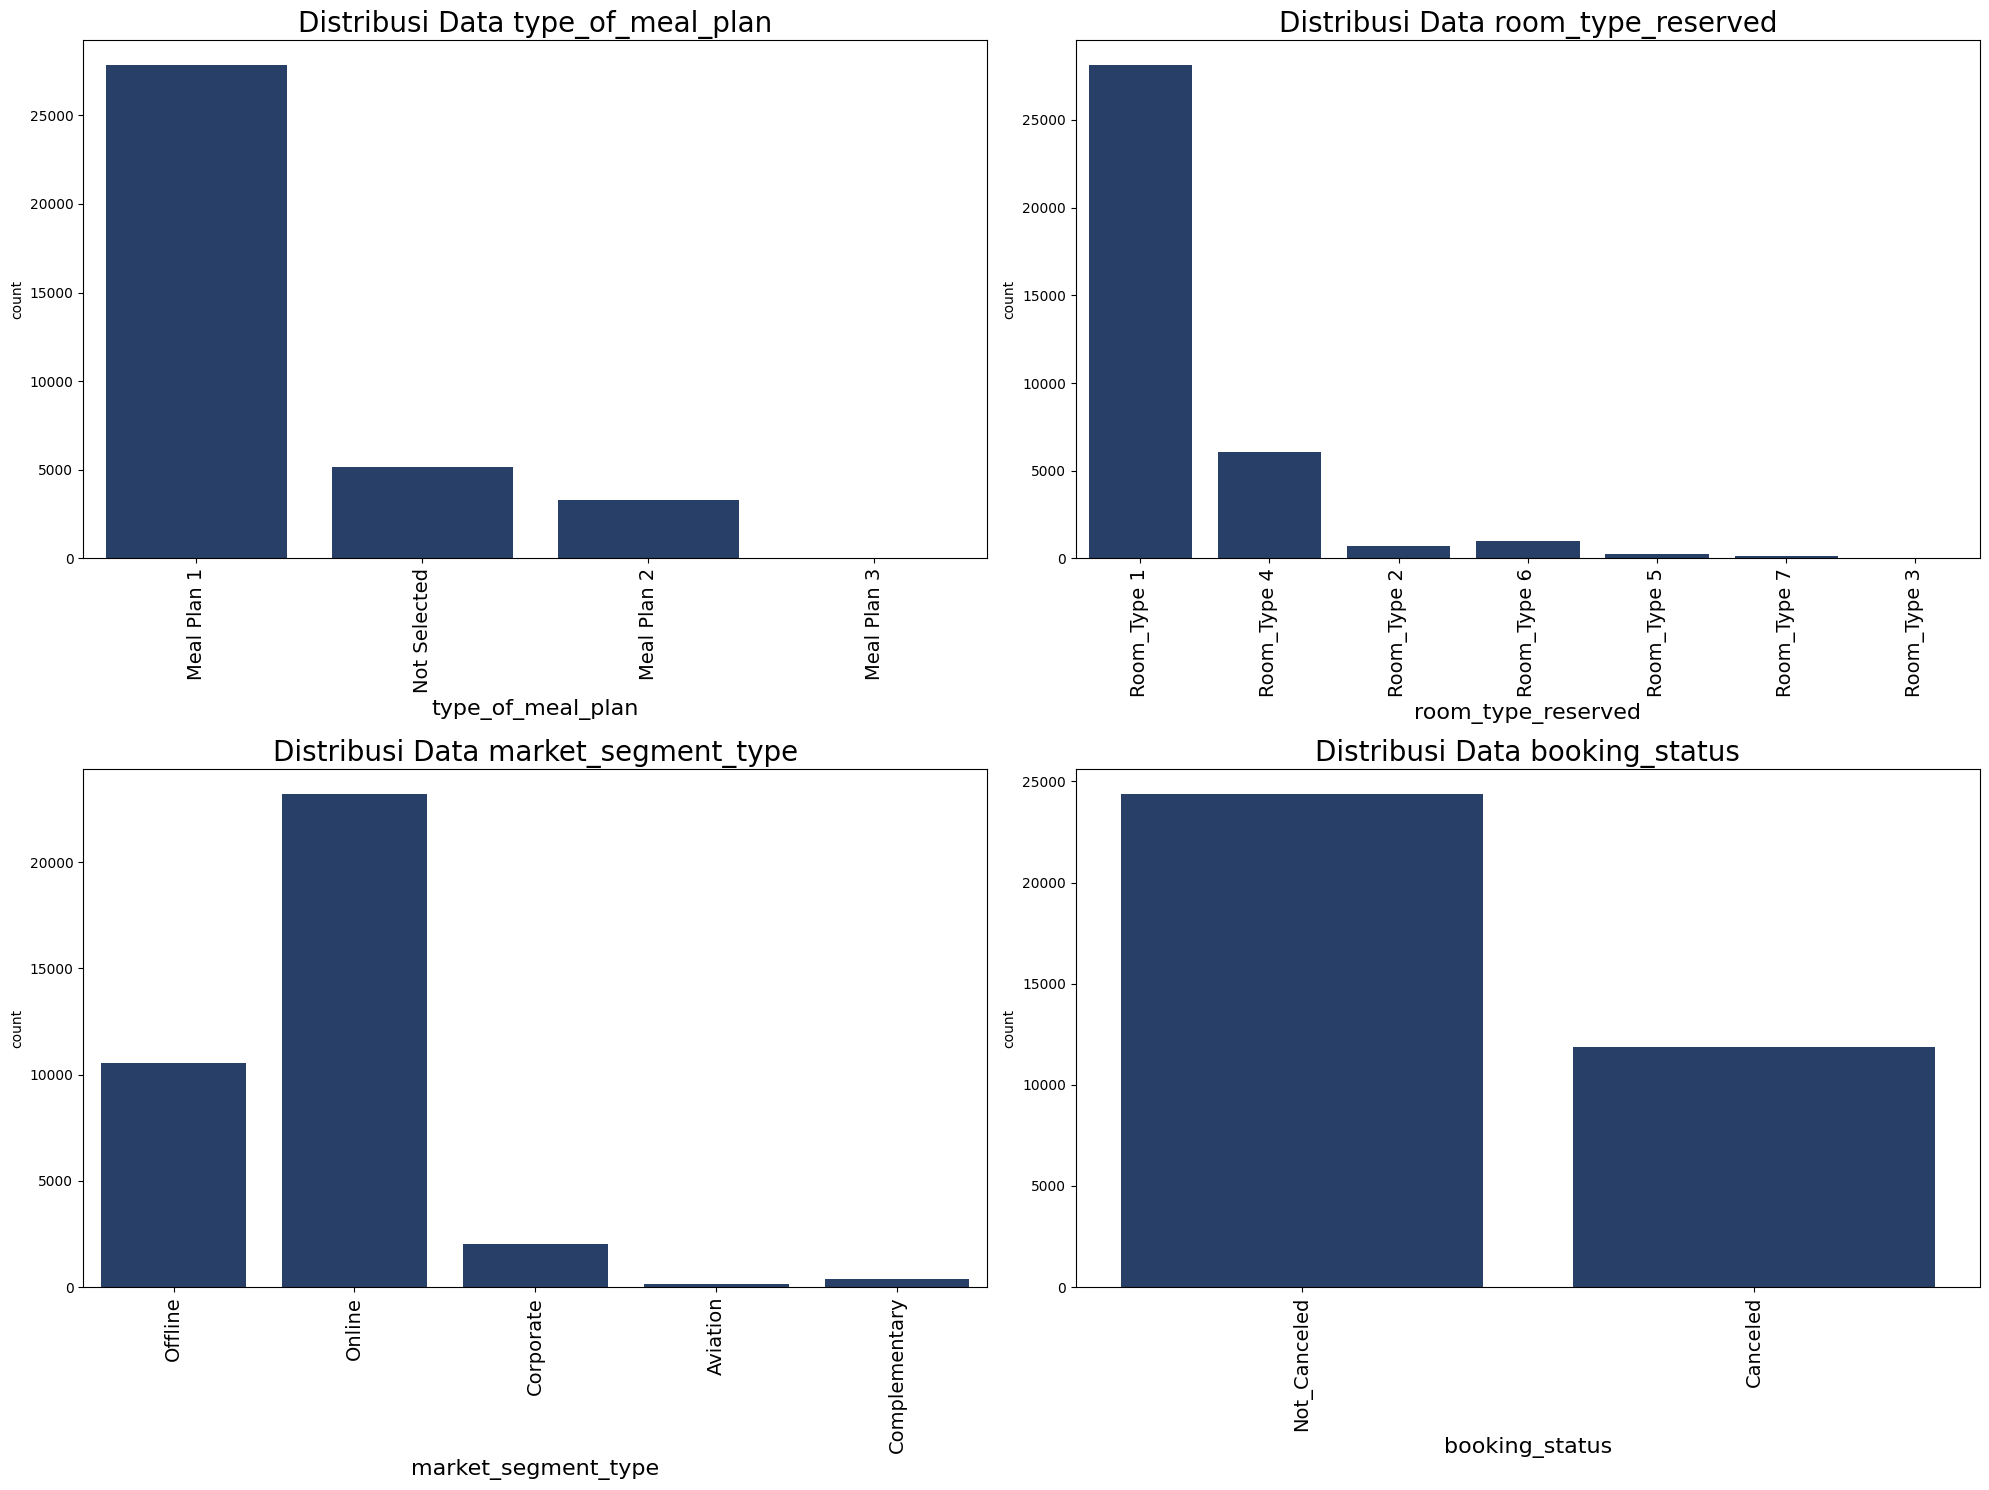

In [68]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

for i, col in enumerate(obj_lo_card):
    ax = axes[i // 2, i % 2]
    sns.countplot(data=df, x=df[col], color=color_codes[0], ax=ax)
    ax.set_title(f'Distribusi Data {col}', size= 20)
    ax.set_xlabel(col, fontsize=16)
    ax.tick_params(axis='x', labelsize=14, rotation= 90)
    # ax.set_xticks([])
    # ax.set_xticklabels([])

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Berdasarkan plot di atas, terlihat bahwa:  
- Kolom Meal Plan didominasi dengan Meal Plan 1  
- Kolom Room type didominasi dengan Room Type 1  
- Kolom Segment Type didominasi dengan Segment Type Online  
- Kolom Booking Status didominasi dengan Not Canceled. Ini artinya sebagian besar booking masih lebih banyak tidak cancel.  

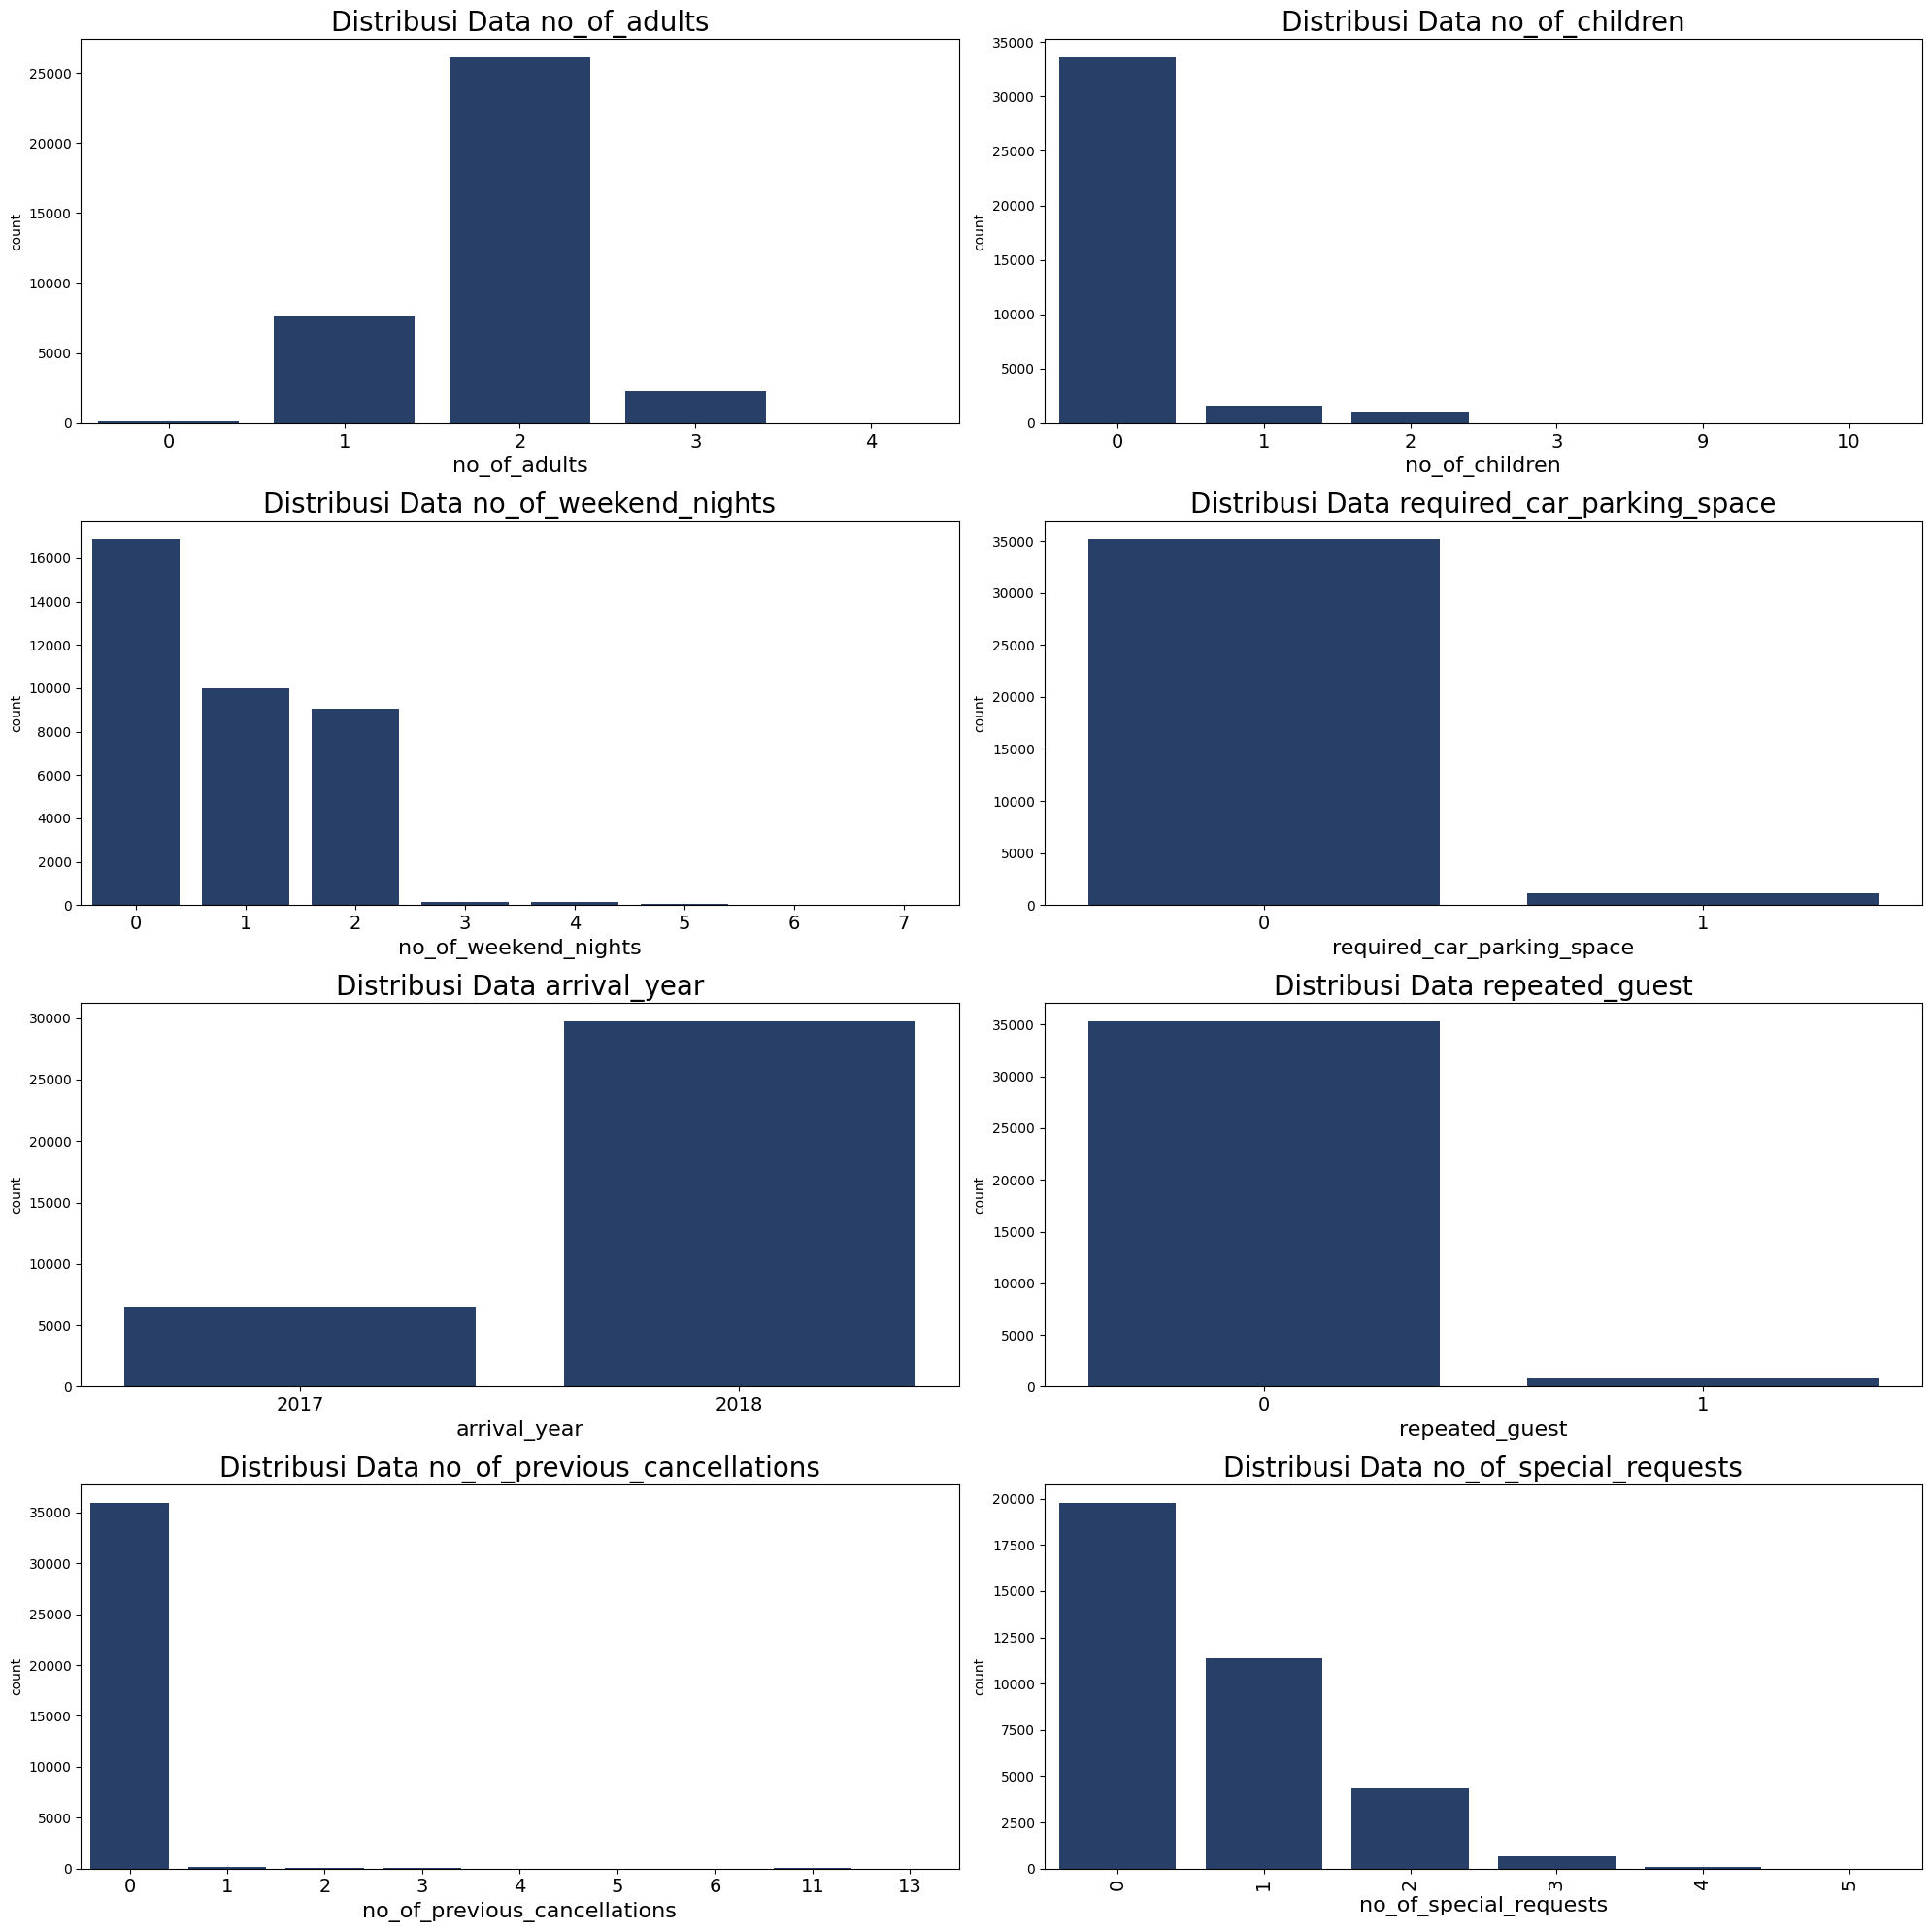

In [69]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20))

for i, col in enumerate(num_lo_card):
    ax = axes[i // 2, i % 2]
    sns.countplot(data=df, x=df[col], color=color_codes[0], ax=ax)
    ax.set_title(f'Distribusi Data {col}', size= 20)
    ax.set_xlabel(col, fontsize=16)
    ax.tick_params(axis='x', labelsize=14)
    # ax.set_xticks([])
    # ax.set_xticklabels([])

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Berdasarkan plot di atas:  
- Kolom no_of_adults didominasi oleh 2 orang dewasa. Bisa disimpulkan mayoritas adalah tamu pasangan.  
- Kolom no_of_children hanya sedikit yang membawa anak-anak. Sebagian besar tidak membawa anak-anak.  
 - Kolom no_of_weekend_nights juga
Kolom required_car_parking_space,
Kolom arrival_year,
Kolom repeated_guest,
Kolom no_of_previous_cancellations,
Kolom no_of_special_requests]

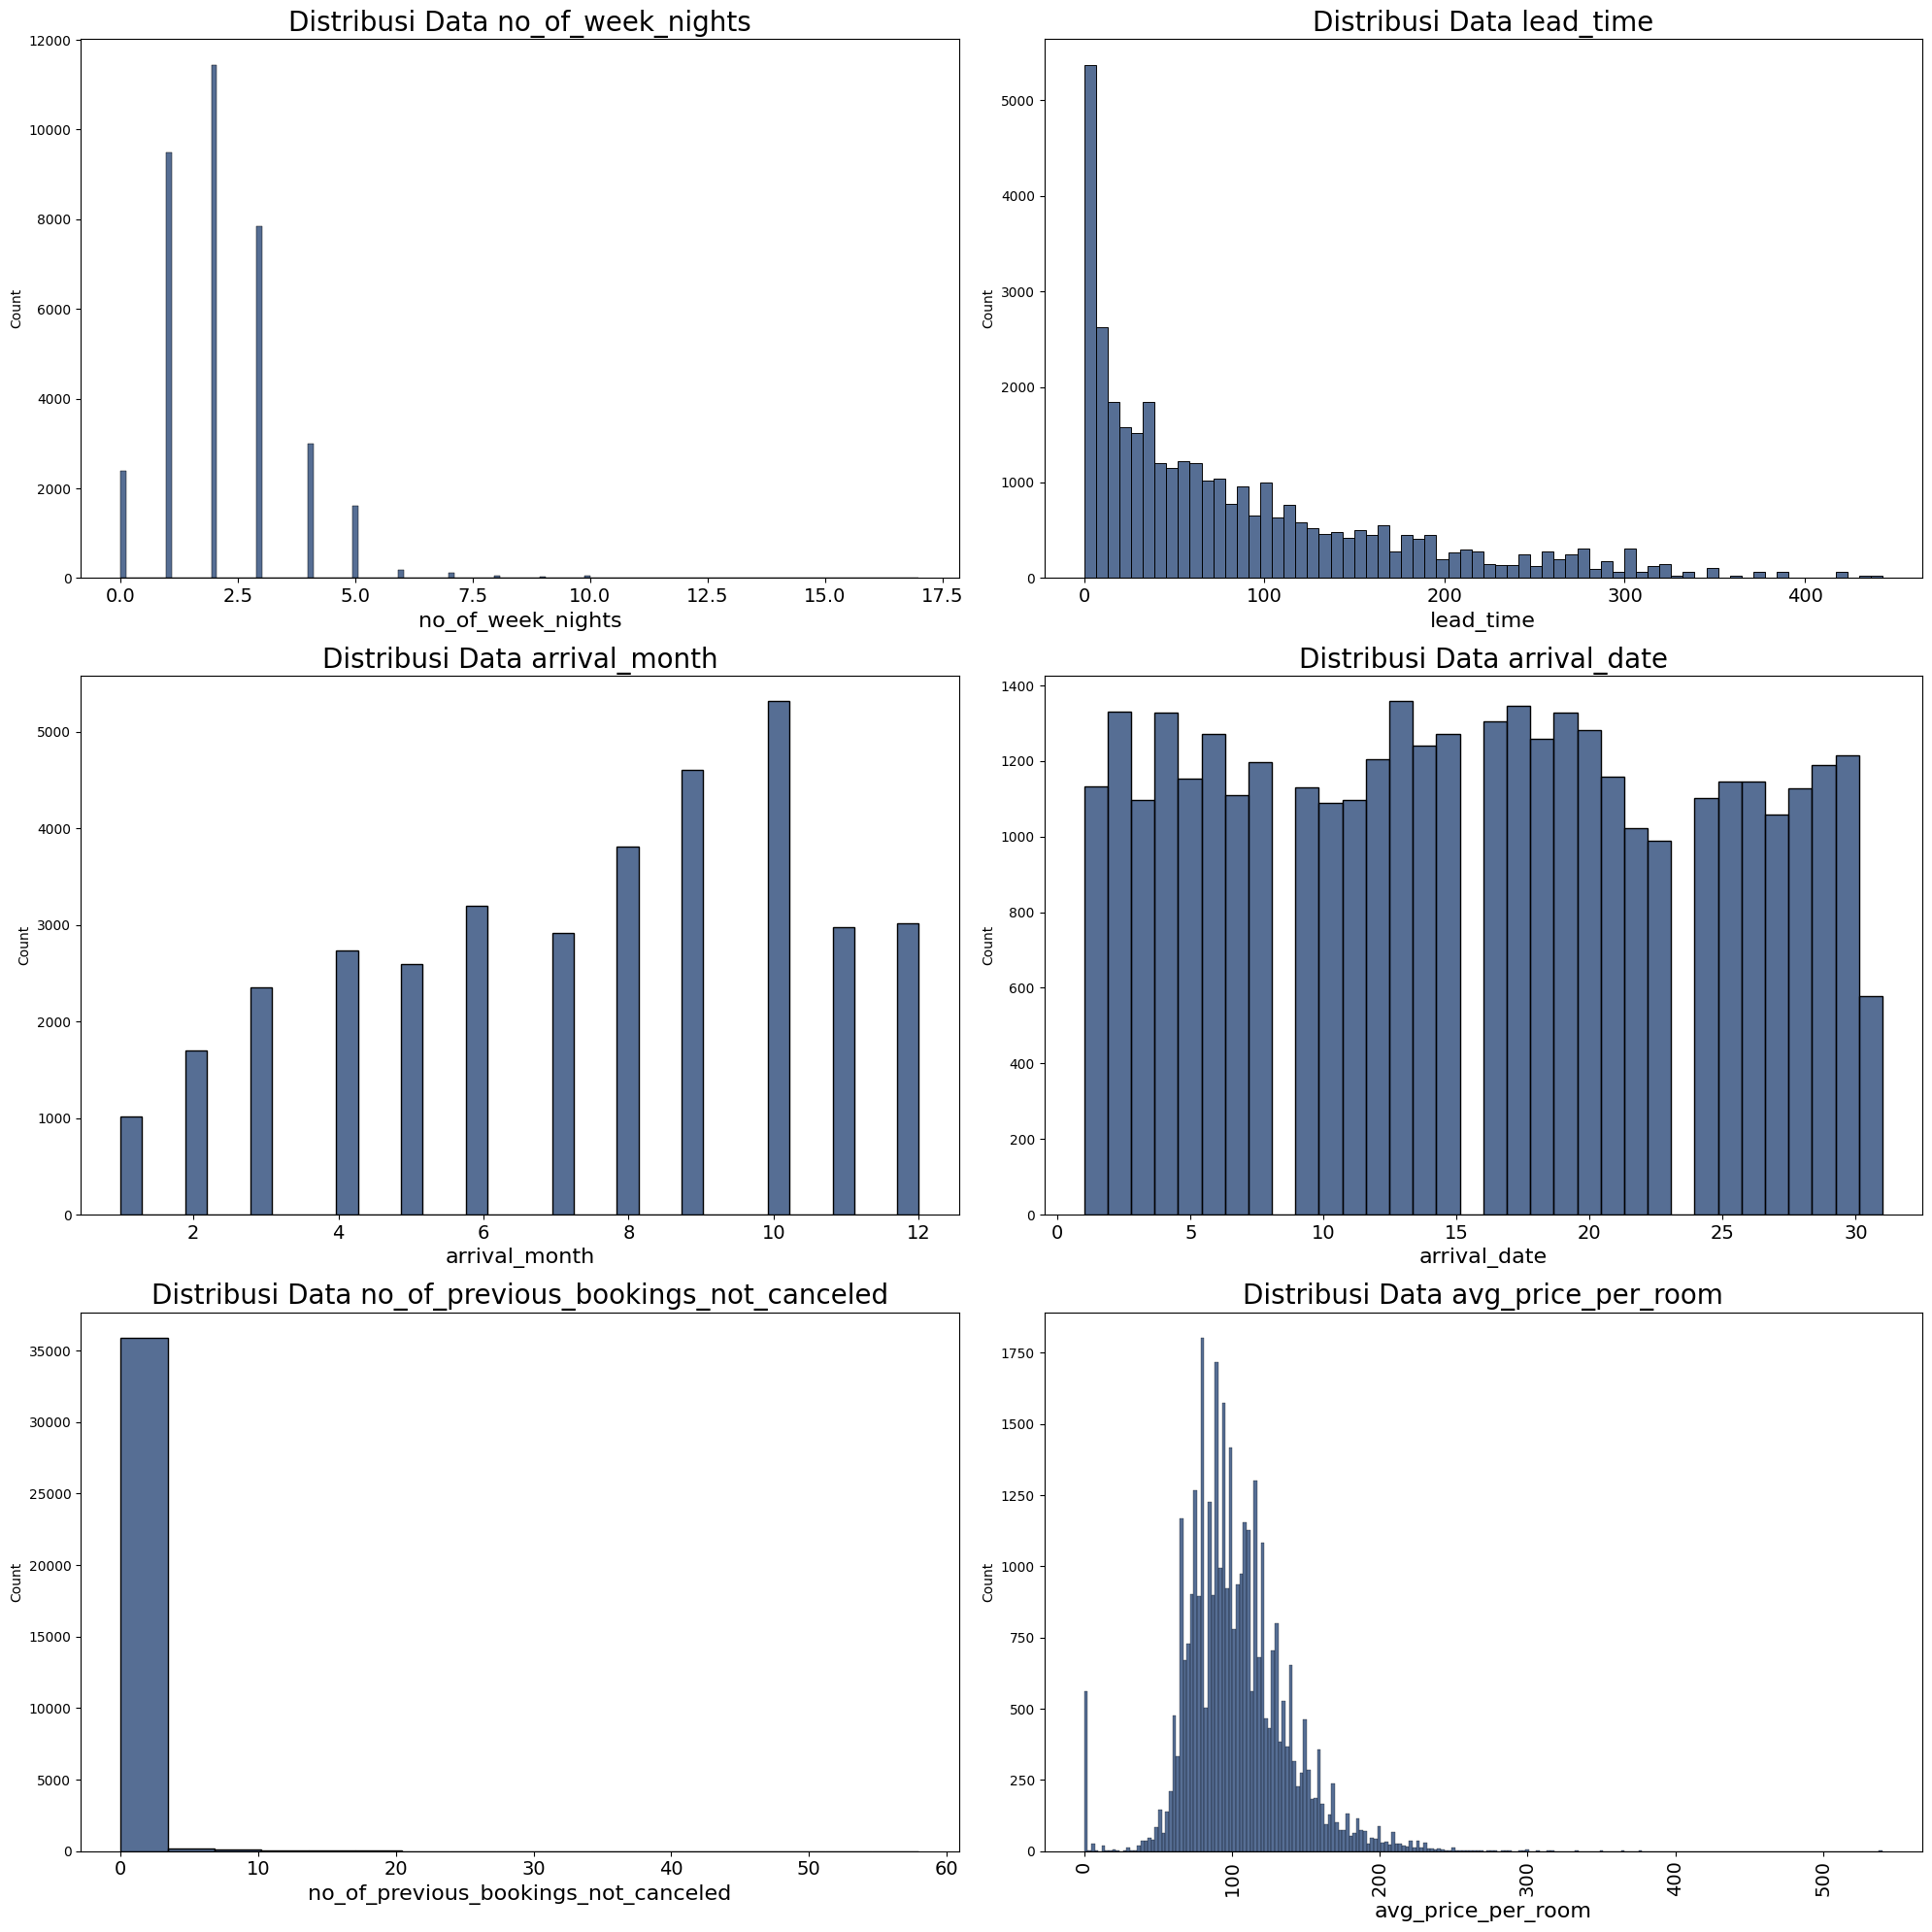

In [70]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

for i, col in enumerate(num_hi_card):
    ax = axes[i // 2, i % 2]
    sns.histplot(data=df, x=df[col], color=color_codes[0], ax=ax)
    ax.set_title(f'Distribusi Data {col}', size= 20)
    ax.set_xlabel(col, fontsize=16)
    ax.tick_params(axis='x', labelsize=14)
    # ax.set_xticks([])
    # ax.set_xticklabels([])

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [71]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
no_of_adults,36275.0,1.844962,0.518715,0.0,2.0,2.00,2.0,4.0
no_of_children,36275.0,0.105279,0.402648,0.0,0.0,0.00,0.0,10.0
no_of_weekend_nights,36275.0,0.810724,0.870644,0.0,0.0,1.00,2.0,7.0
no_of_week_nights,36275.0,2.204300,1.410905,0.0,1.0,2.00,3.0,17.0
required_car_parking_space,36275.0,0.030986,0.173281,0.0,0.0,0.00,0.0,1.0
lead_time,36275.0,85.232557,85.930817,0.0,17.0,57.00,126.0,443.0
arrival_year,36275.0,2017.820427,0.383836,2017.0,2018.0,2018.00,2018.0,2018.0
arrival_month,36275.0,7.423653,3.069894,1.0,5.0,8.00,10.0,12.0
arrival_date,36275.0,15.596995,8.740447,1.0,8.0,16.00,23.0,31.0
repeated_guest,36275.0,0.025637,0.158053,0.0,0.0,0.00,0.0,1.0


## Komposisi Booking Status

In [72]:
c= df[df['booking_status']== 'Canceled']
nc= df[df['booking_status']== 'Not_Canceled']

In [73]:
threshold = 10
c_obj_hi_card = []
c_obj_lo_card = []
c_num_lo_card = []
c_num_hi_card = []

for col in c.columns:
    if c[col].dtype == 'object':
        if c[col].nunique() >= threshold:
            c_obj_hi_card.append(col)
        else:
            c_obj_lo_card.append(col)
    elif c[col].dtype in ['int', 'float']:
        if c[col].nunique() <= threshold:
            c_num_lo_card.append(col)
        else:
            c_num_hi_card.append(col)

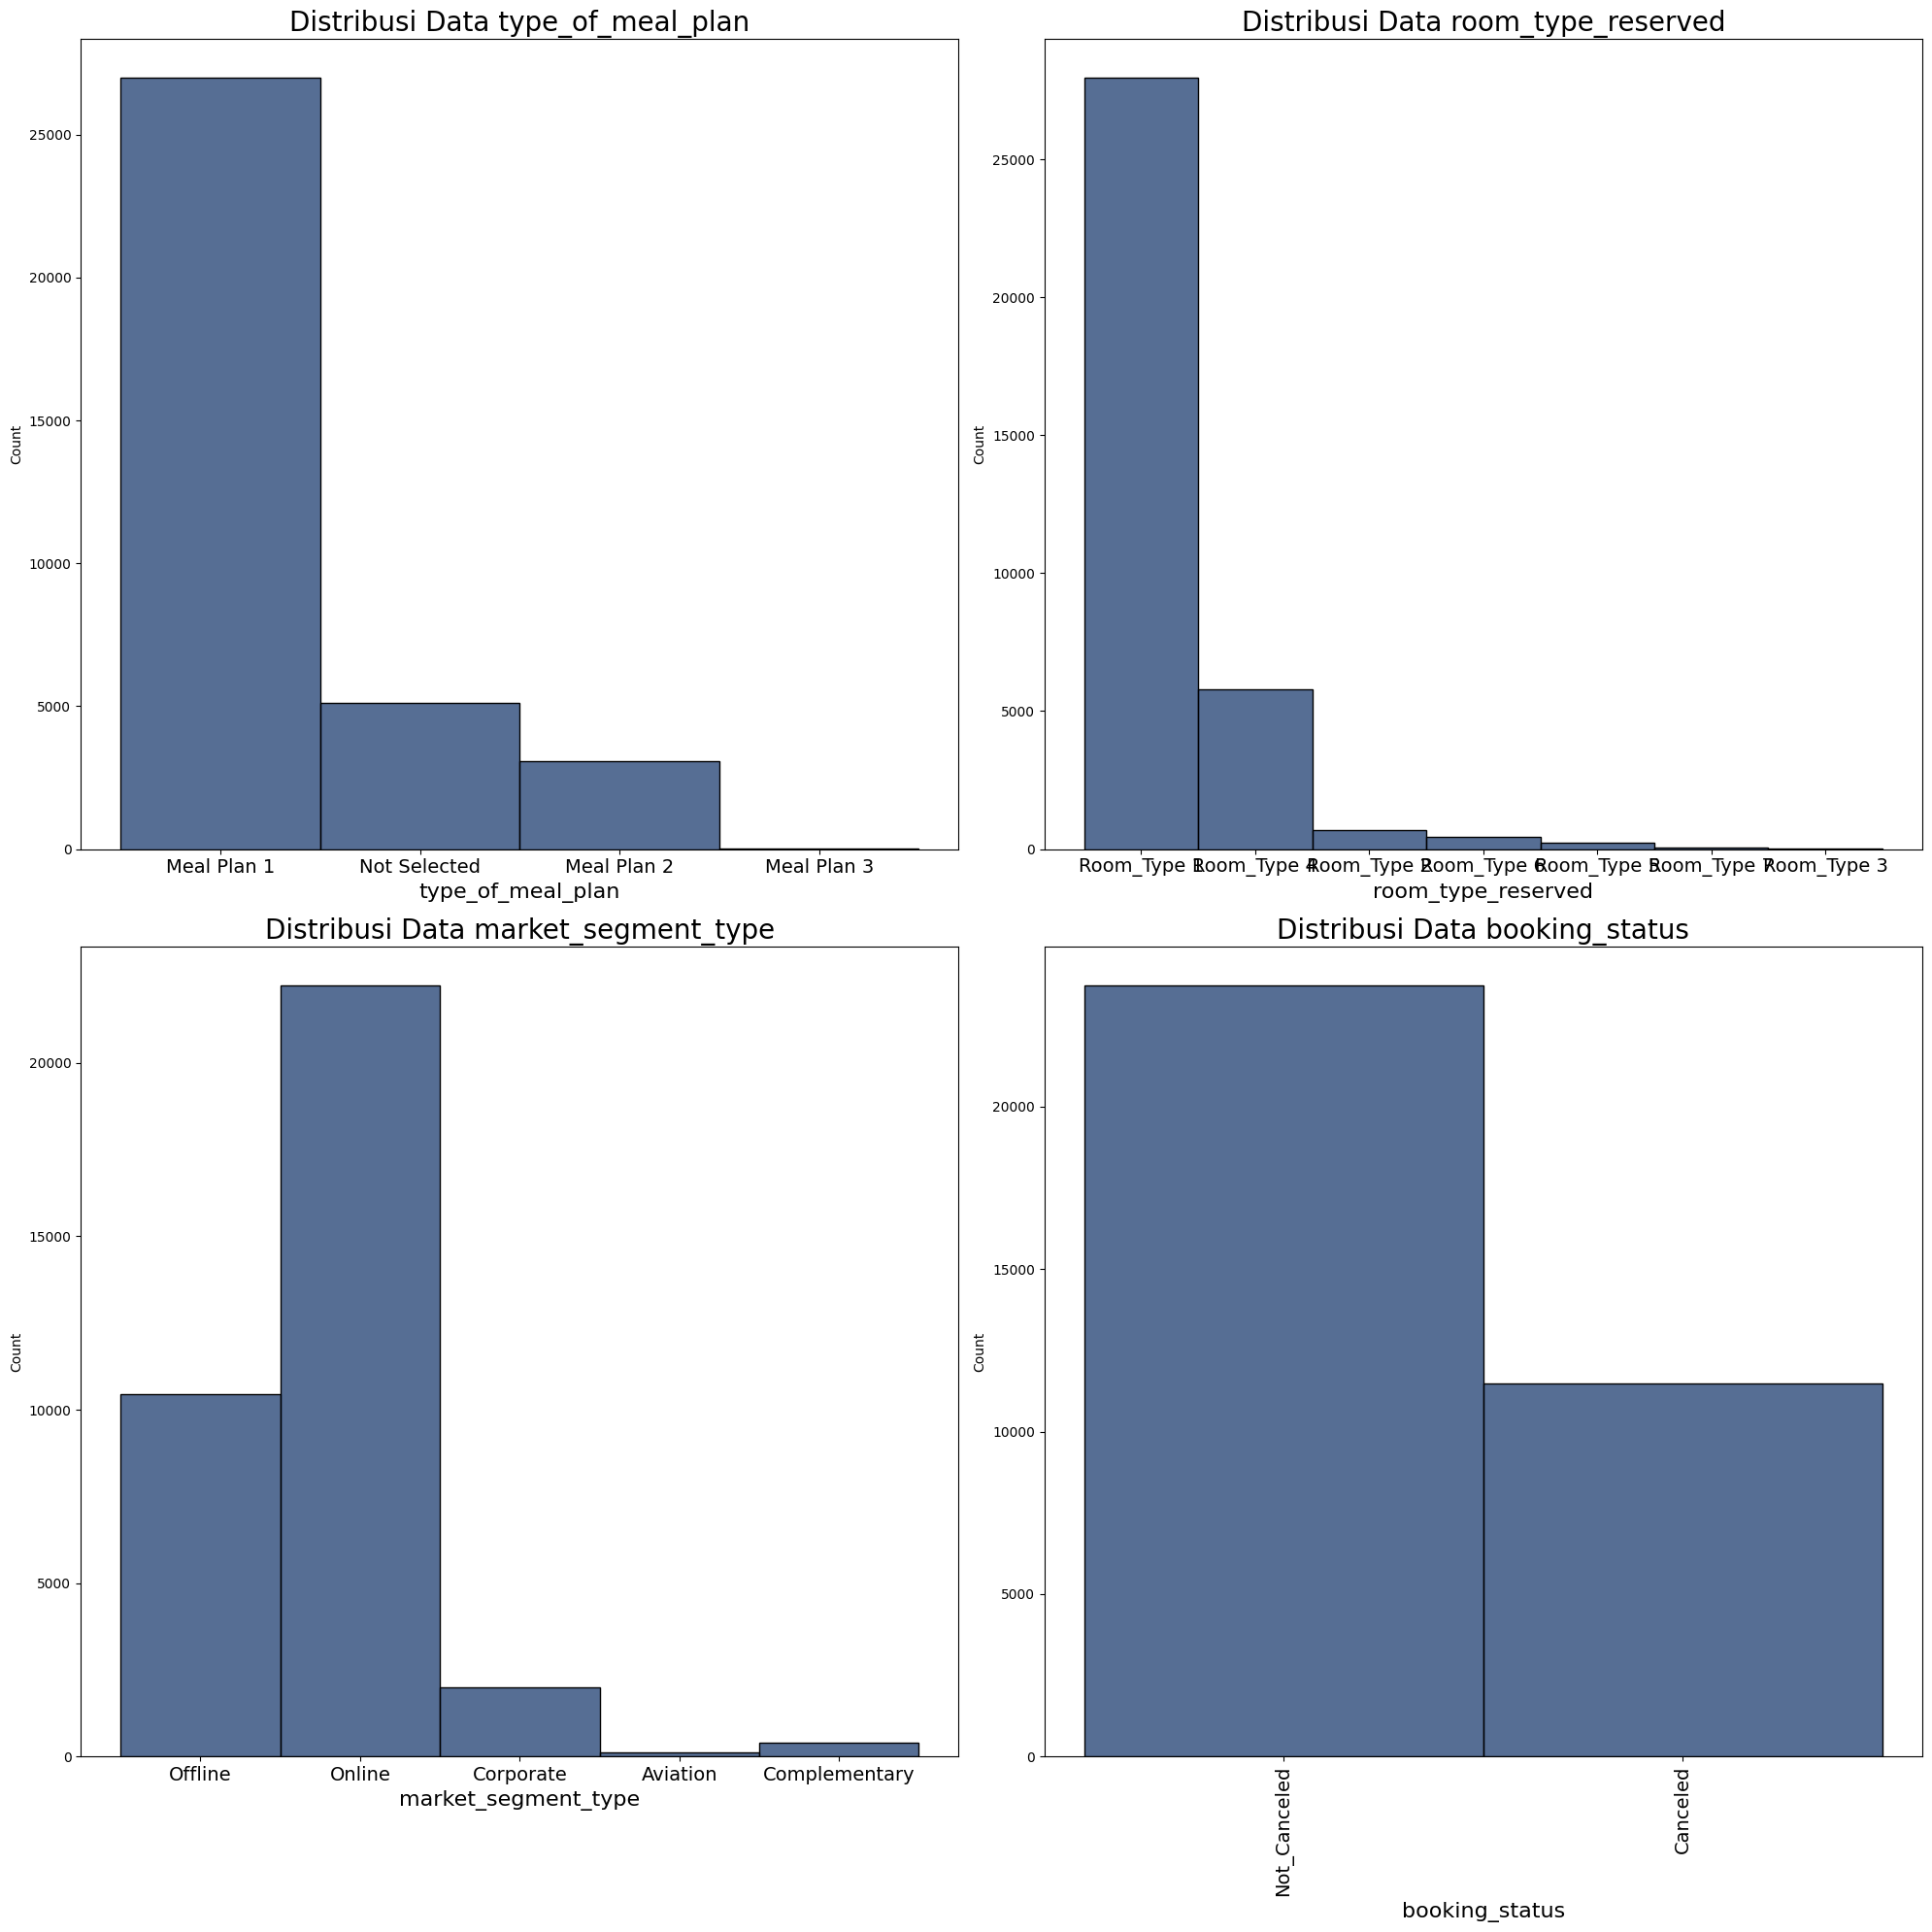

In [109]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for i, col in enumerate(c_obj_lo_card):
    ax = axes[i // 2, i % 2]
    sns.histplot(data=df, x=df[col], color=color_codes[0], ax=ax)
    ax.set_title(f'Distribusi Data {col}', size= 20)
    ax.set_xlabel(col, fontsize=16)
    ax.tick_params(axis='x', labelsize=14)
    # ax.set_xticks([])
    # ax.set_xticklabels([])

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Feature Engineering

## Outlier Handling

Saya akan Cek outliers dengan menggunakan boxplot hanya pada num_hi_card tepatnya harga rata-rata kamar saja.  

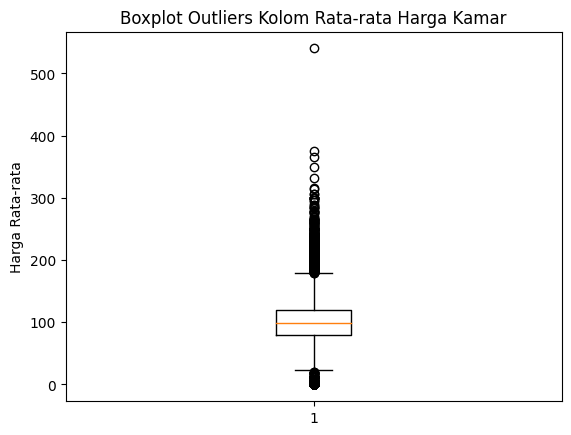

In [75]:
plt.boxplot(df['avg_price_per_room'])
plt.title('Boxplot Outliers Kolom Rata-rata Harga Kamar')
plt.ylabel('Harga Rata-rata')
plt.show()

In [76]:
Q1= df['avg_price_per_room'].quantile(0.25)
Q3= df['avg_price_per_room'].quantile(0.75)
IQR= Q3-Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_bound, upper_bound

(20.749999999999993, 179.55)

In [77]:
outlier_indices= df[df['avg_price_per_room'] >upper_bound].index
df= df.drop(outlier_indices)
print(f"Outlier telah di hapus dan kini ukuran dataset menjadi: {df.shape}")

Outlier telah di hapus dan kini ukuran dataset menjadi: (35206, 19)


## Cek Korelasi

In [78]:
df_corr= df.copy()
df_corr.drop(['Booking_ID'], axis= 1, inplace= True)

In [79]:
obj_lo_card

['type_of_meal_plan',
 'room_type_reserved',
 'market_segment_type',
 'booking_status']

In [80]:
encode= LabelEncoder()

for col in obj_lo_card:
  df_corr[col]= encode.fit_transform(df_corr[col])

df_corr

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,0,0,0,224,2017,10,2,3,0,0,0,65.00,0,1
1,2,0,2,3,3,0,0,5,2018,11,6,4,0,0,0,106.68,1,1
2,1,0,2,1,0,0,0,1,2018,2,28,4,0,0,0,60.00,0,0
3,2,0,0,2,0,0,0,211,2018,5,20,4,0,0,0,100.00,0,0
4,2,0,1,1,3,0,0,48,2018,4,11,4,0,0,0,94.50,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,3,0,2,6,0,0,3,85,2018,8,3,4,0,0,0,167.80,1,1
36271,2,0,1,3,0,0,0,228,2018,10,17,4,0,0,0,90.95,2,0
36272,2,0,2,6,0,0,0,148,2018,7,1,4,0,0,0,98.39,2,1
36273,2,0,0,3,3,0,0,63,2018,4,21,4,0,0,0,94.50,0,0


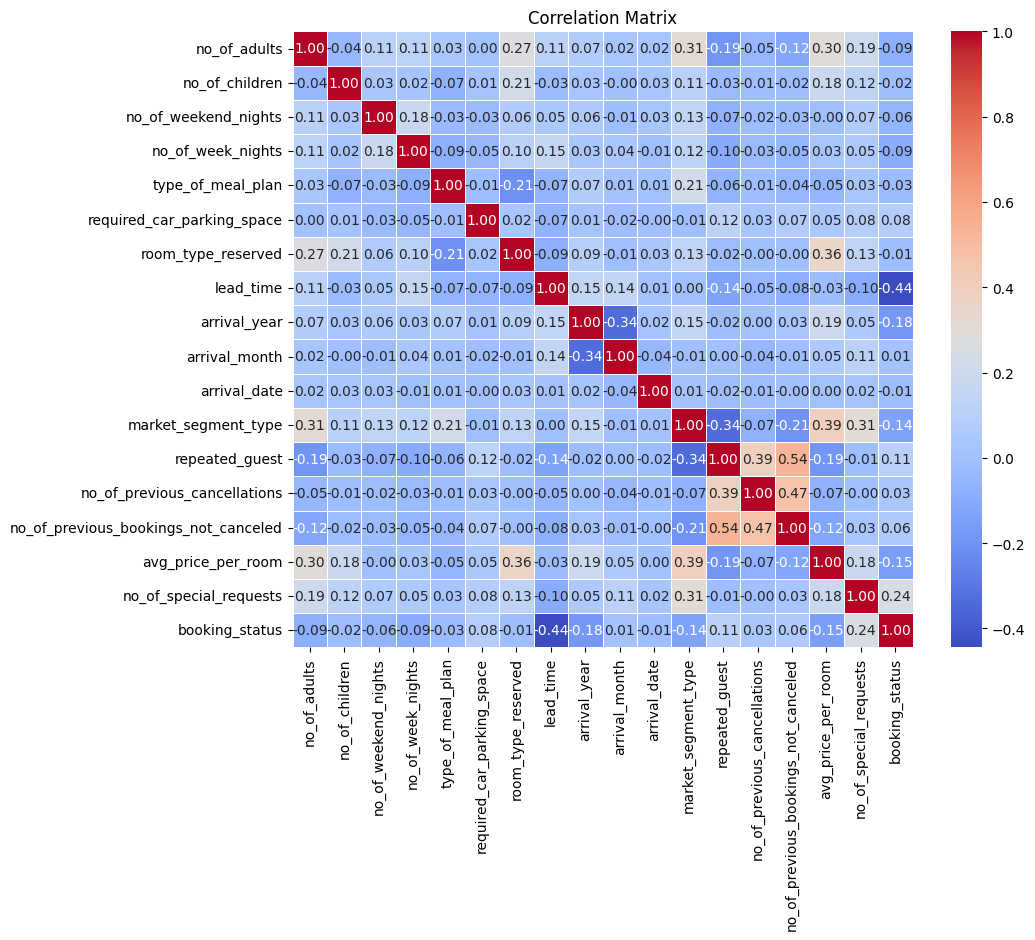

In [81]:
correlation_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [82]:
correlation_matrix[correlation_matrix['booking_status'] > 0.01]['booking_status'].sort_values(ascending=False)

booking_status                          1.000000
no_of_special_requests                  0.244753
repeated_guest                          0.108445
required_car_parking_space              0.084194
no_of_previous_bookings_not_canceled    0.060851
no_of_previous_cancellations            0.034057
Name: booking_status, dtype: float64

In [83]:
X= df.drop('booking_status', axis= 1)
y= df['booking_status']
X

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,ID00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0
1,ID00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1
2,ID00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0
3,ID00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0
4,ID00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,ID36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1
36271,ID36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2
36272,ID36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2
36273,ID36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0


In [84]:
encode = LabelEncoder()

column = ['booking_status']
for col in column:
    y = encode.fit_transform(y)

y

array([1, 1, 0, ..., 1, 0, 1])

In [85]:
# Splitting between Train-Set, Val-Set, and Test-Set

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (25436, 18)
Val Size   :  (4489, 18)
Test Size  :  (5281, 18)


In [86]:
obj_lo_card

['type_of_meal_plan',
 'room_type_reserved',
 'market_segment_type',
 'booking_status']

In [87]:
X_train.drop(['Booking_ID'], axis= 1, inplace= True)
X_val.drop(['Booking_ID'], axis= 1, inplace= True)
X_test.drop(['Booking_ID'], axis= 1, inplace= True)

X_train

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
10829,2,1,0,3,Meal Plan 1,0,Room_Type 1,50,2017,12,31,Offline,0,0,0,71.33,0
1758,2,0,0,4,Meal Plan 1,0,Room_Type 4,78,2018,4,5,Online,0,0,0,97.33,0
27222,2,0,0,1,Meal Plan 1,0,Room_Type 1,180,2017,10,16,Offline,0,0,0,70.00,0
19290,2,0,0,2,Meal Plan 2,0,Room_Type 1,39,2017,8,14,Offline,0,0,0,101.50,0
31731,2,0,0,3,Meal Plan 1,0,Room_Type 1,20,2018,11,24,Online,0,0,0,104.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10548,1,0,2,7,Not Selected,0,Room_Type 1,35,2018,12,7,Online,0,0,0,79.20,0
25778,2,0,0,5,Meal Plan 1,0,Room_Type 1,0,2017,9,8,Online,0,0,0,146.40,2
3495,1,0,2,7,Meal Plan 1,0,Room_Type 1,109,2017,7,15,Online,0,0,0,68.00,1
12458,2,0,1,2,Meal Plan 1,0,Room_Type 1,41,2017,10,16,Online,0,0,0,105.90,2


## Pipeline

In [88]:
num_columns = X_train.select_dtypes(include=np.number).columns.tolist()
cat_columns = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical Columns antara lain:\n{num_columns}")
print(f"Categorical Columns antara lain:\n{cat_columns}")

Numerical Columns antara lain:
['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']
Categorical Columns antara lain:
['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']


### Create A Pipeline

In [89]:
num_pipeline = make_pipeline(StandardScaler())

cat_pipeline = make_pipeline(OneHotEncoder())

final_pipeline = ColumnTransformer([
    ('pipe_num', num_pipeline, num_columns),
    ('pipe_cat', cat_pipeline, cat_columns)
])

### Fit and Transform

In [90]:
X_train = final_pipeline.fit_transform(X_train)
X_val = final_pipeline.transform(X_val)
X_test = final_pipeline.transform(X_test)
X_train.shape

(25436, 30)

# ANN Training - Sequential API

## Model Definition

Saya mulai dengan menggunakan random weight dll

In [91]:
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

Saya definisikan model ini dengan 18 neuron pada hidden layer pertama, 8 ke2 dan 1 binary output

In [92]:
# Create Sequential API



model_sequential = Sequential()
model_sequential.add(Dense(18,
                           activation='relu',
                           kernel_initializer=tf.keras.initializers.HeNormal(seed),
                           input_shape=(30,)))
model_sequential.add(Dense(8,
                           activation='relu',
                           kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_sequential.add(Dense(1,
                           activation='sigmoid',
                           kernel_initializer=tf.keras.initializers.GlorotNormal(seed)))

# Compile
model_sequential.compile(loss='binary_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])
model_sequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 18)                558       
                                                                 
 dense_1 (Dense)             (None, 8)                 152       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 719 (2.81 KB)
Trainable params: 719 (2.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


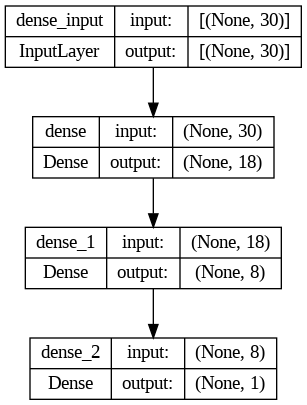

In [93]:
tf.keras.utils.plot_model(model_sequential, show_shapes=True)

### Model Training

In [94]:
history_seq = model_sequential.fit(X_train,
                                   y_train,
                                   epochs=20,
                                   validation_data=(X_val, y_val),
                                   batch_size=10)

Epoch 1/20
2544/2544 [==============================] - 11s 3ms/step - loss: 0.4469 - accuracy: 0.7828 - val_loss: 0.3900 - val_accuracy: 0.8236
Epoch 2/20
2544/2544 [==============================] - 13s 5ms/step - loss: 0.3931 - accuracy: 0.8205 - val_loss: 0.3778 - val_accuracy: 0.8356
Epoch 3/20
2544/2544 [==============================] - 6s 2ms/step - loss: 0.3817 - accuracy: 0.8271 - val_loss: 0.3686 - val_accuracy: 0.8414
Epoch 4/20
2544/2544 [==============================] - 5s 2ms/step - loss: 0.3726 - accuracy: 0.8308 - val_loss: 0.3628 - val_accuracy: 0.8454
Epoch 5/20
2544/2544 [==============================] - 6s 2ms/step - loss: 0.3655 - accuracy: 0.8353 - val_loss: 0.3549 - val_accuracy: 0.8490
Epoch 6/20
2544/2544 [==============================] - 6s 2ms/step - loss: 0.3595 - accuracy: 0.8379 - val_loss: 0.3550 - val_accuracy: 0.8481
Epoch 7/20
2544/2544 [==============================] - 9s 4ms/step - loss: 0.3555 - accuracy: 0.8399 - val_loss: 0.3511 - val_accurac

### Model Evaluation

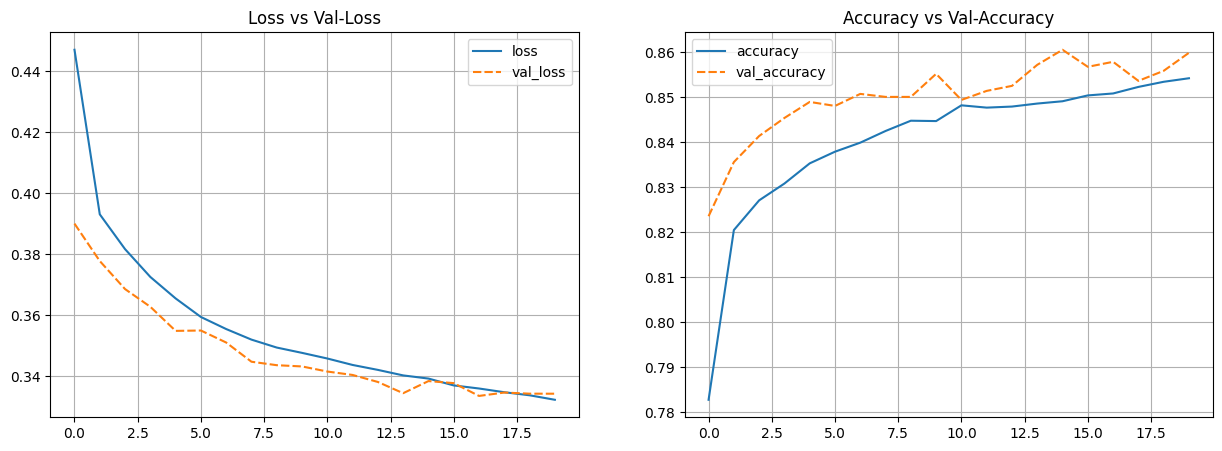

In [95]:
history_seq_df = pd.DataFrame(history_seq.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_seq_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_seq_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [96]:
# Predict Test-Set

model_sequential.predict(X_test)

166/166 [==============================] - 0s 1ms/step


array([[0.00257731],
       [0.2876648 ],
       [0.22207241],
       ...,
       [0.26715282],
       [0.45957223],
       [0.9426407 ]], dtype=float32)

In [97]:
# Model Evaluation (Test-Set)

y_pred_seq = model_sequential(X_test)
y_pred_seq = np.where(y_pred_seq >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_seq))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1721
           1       0.89      0.89      0.89      3560

    accuracy                           0.85      5281
   macro avg       0.83      0.83      0.83      5281
weighted avg       0.85      0.85      0.85      5281



Dari sini saya bisa asumsikan jika menggunakan recall average baik macro maupun weight di atas 8. Saya akan menggunakan ini, karena pada dasarnya ini model yang simpel dengan dataset dan turunannya yang tidak begitu kompleks

# ANN Training - Functional API

## Model Definition

Sebagai perbandingan saya juga akan mendefinisikan Functional

In [98]:
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [99]:
# Create functional model

input_layer = Input(shape=(30,))
hidden_layer_1 = Dense(16, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)) (input_layer)
hidden_layer_2 = Dense(8, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)) (hidden_layer_1)

concat_layer = concatenate([input_layer, hidden_layer_2])
output_layer = Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotNormal(seed)) (concat_layer)

model_functional = Model(inputs=input_layer, outputs=output_layer)

# Compile
model_functional.compile(loss='binary_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])
model_functional.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 16)                   496       ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 8)                    136       ['dense[0][0]']               
                                                                                                  
 concatenate (Concatenate)   (None, 38)                   0         ['input_1[0][0]',             
                                                                     'dense_1[0][0]']         

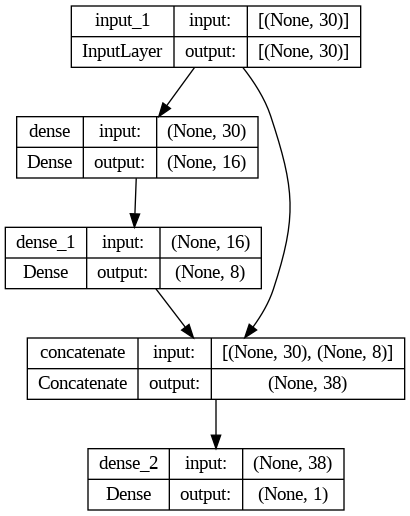

In [100]:
tf.keras.utils.plot_model(model_functional, show_shapes=True)

## Model Training

In [101]:
history_func = model_functional.fit(X_train,
                                    y_train,
                                    epochs=20,
                                    validation_data=(X_val, y_val),
                                    batch_size=10)

Epoch 1/20
2544/2544 [==============================] - 7s 2ms/step - loss: 0.4577 - accuracy: 0.7811 - val_loss: 0.3965 - val_accuracy: 0.8291
Epoch 2/20
2544/2544 [==============================] - 5s 2ms/step - loss: 0.3996 - accuracy: 0.8164 - val_loss: 0.3838 - val_accuracy: 0.8363
Epoch 3/20
2544/2544 [==============================] - 6s 2ms/step - loss: 0.3878 - accuracy: 0.8228 - val_loss: 0.3750 - val_accuracy: 0.8340
Epoch 4/20
2544/2544 [==============================] - 5s 2ms/step - loss: 0.3808 - accuracy: 0.8271 - val_loss: 0.3694 - val_accuracy: 0.8374
Epoch 5/20
2544/2544 [==============================] - 5s 2ms/step - loss: 0.3749 - accuracy: 0.8292 - val_loss: 0.3659 - val_accuracy: 0.8383
Epoch 6/20
2544/2544 [==============================] - 7s 3ms/step - loss: 0.3698 - accuracy: 0.8320 - val_loss: 0.3648 - val_accuracy: 0.8369
Epoch 7/20
2544/2544 [==============================] - 5s 2ms/step - loss: 0.3670 - accuracy: 0.8353 - val_loss: 0.3579 - val_accuracy:

## Model Evaluation

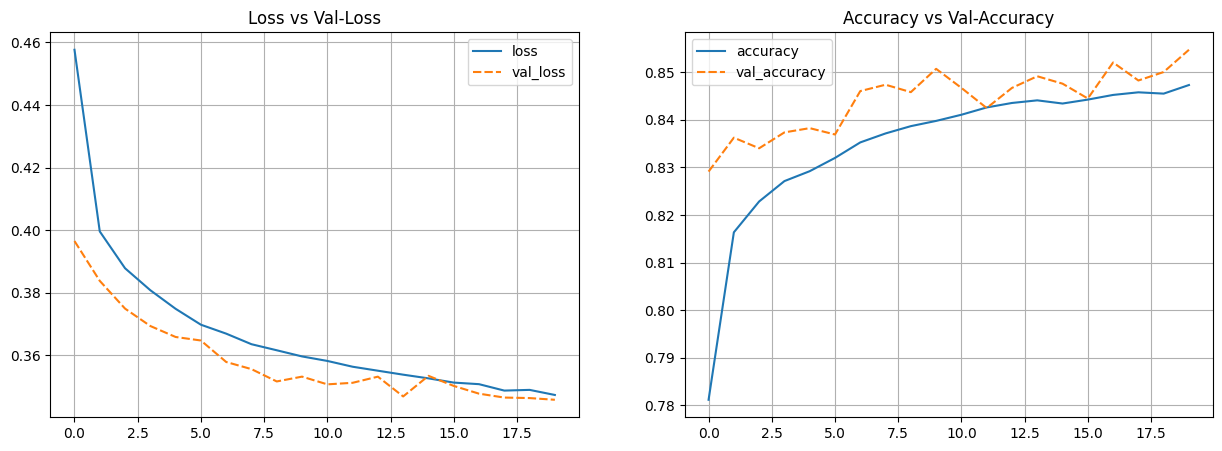

In [102]:
history_func_df = pd.DataFrame(history_func.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_func_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_func_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [103]:
# Predict Test-Set

y_pred_func = model_functional.predict(X_test)
y_pred_func = np.where(y_pred_func >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_func))

166/166 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      1721
           1       0.88      0.89      0.89      3560

    accuracy                           0.84      5281
   macro avg       0.82      0.82      0.82      5281
weighted avg       0.84      0.84      0.84      5281



Hasil Evaluasi slighlty similar. Tetapi sesuai pernyataan sebelumnya, saya akan gunakan model sequantial.  

# Model Saving (Sequential API)

In [104]:
with open('hotel_pipeline.pkl', 'wb') as file_1:
  pickle.dump(final_pipeline, file_1)

In [105]:
model_sequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 18)                558       
                                                                 
 dense_1 (Dense)             (None, 8)                 152       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 719 (2.81 KB)
Trainable params: 719 (2.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Freeze model

In [106]:
model_sequential.trainable = False
model_sequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 18)                558       
                                                                 
 dense_1 (Dense)             (None, 8)                 152       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 719 (2.81 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 719 (2.81 KB)
_________________________________________________________________


## Save Model

In [107]:
model_sequential.save('hotel_model.h5')
model_sequential.save('hotel_model.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Pengambilan Keputusan

Penting untuk mendefinisikan metode evaluasi apa yang digunakan. layaknya wanita hamil yang tidak boleh salah prediksi negatif, ini juga sama. Jangan sampai tamu yang sebetulnya positif perform tetapi dinyatakan cancel.  

Saya sudah menyimpan model **sequntial** yang lebih simpel dengan mengantongi hasil score recall sebesar 0.83 dan 0.85